## Research Visualisations

This notebook plots comparisons between fight for sight publications and general eye research publications in the form of visualisation maps, word clouds, and fraction of each topic over time.

This notebook can be customised in two ways - by picking a different range of years to consider, and choosing which topic number to plot more detailed information about.

Plots are saved in the plots/topics folder.

Note that the general eye research dataset as things stand is not updateable so will be limited to between the years 2000 and 2018.

To run this notebook go to Kernel -> Restart & Run All

### Year Range to Investigate

In [1]:
START_YEAR = 2008
END_YEAR = 2018

### Load Data

In [39]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pickle
from sklearn.externals import joblib

import pandas as pd

from PreprocessText import lemmatize_abstracts

from wordcloud import WordCloud

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
print('Done.')

print('loading and transforming ffs data')
df = pd.read_pickle('data/EPMC/ffs_papers.pkl')
df.set_index('pmid',inplace=True)
print(len(df),'rows')

ffs_abstracts = df.loc[~df['abstractText'].isnull(),'abstractText']

pubYear = pd.to_datetime(df['firstPublicationDate']).dt.year.astype(int)
pubYear.name = 'pubYear'

del df

ffs_abstracts = ffs_abstracts[(pubYear>=START_YEAR) & (pubYear<=END_YEAR)]
pubYear = pubYear[(pubYear>=START_YEAR) & (pubYear<=END_YEAR)]

ffs_abstracts = lemmatize_abstracts(ffs_abstracts)

pmids = ffs_abstracts.index
ffs_abstracts.head()

print('counting')
countvec = joblib.load('models/sklearn/CountVec.joblib')
features = countvec.get_feature_names()
ffs_counts = countvec.transform(ffs_abstracts)
del countvec

print('lda')
lda = joblib.load('models/sklearn/LDA_50topics_alleyekw.joblib') 
topics = pd.DataFrame(lda.components_,columns=features)

ffs_lda_vectors = lda.transform(ffs_counts)
ffs_lda_vectors = pd.DataFrame(ffs_lda_vectors,index=pmids)

ffs_lda_vectors = ffs_lda_vectors[ffs_lda_vectors.max(axis=1)>0.2]
ffs_topics = ffs_lda_vectors.idxmax(axis=1)

ffs_abstracts = ffs_abstracts[ffs_lda_vectors.index]
pmids = pmids[pmids.isin(ffs_lda_vectors.index)]

del lda

print('umap')
umap_file = 'models/umap/eyekws_LDA50_umap_neighbors_30_metric_euclidean_dist_0.pkl'
with open(umap_file,'rb') as f:
    umapper = pickle.load(f)
ffs_umap = umapper.transform(ffs_lda_vectors)
del umapper
print('Done.')

print('loading eye keyword data')
kw_umap = pd.read_pickle('models/umap/eyekws_datapoints.pkl')
kw_umap = kw_umap[(kw_umap['pubYear']>=START_YEAR) & (kw_umap['pubYear']<=END_YEAR)]

kw_lda_vectors = pd.read_pickle('models/sklearn/eyekws_vectors.pkl')
kw_lda_vectors = kw_lda_vectors[(kw_lda_vectors['pubYear']>=START_YEAR) & (kw_lda_vectors['pubYear']<=END_YEAR)]

print('Done.')

Done.
loading and transforming ffs data
1573 rows
Removing missing abstracts
Initial preprocessing: case, punctuation, whitespace
Lemmatizing
counting
lda
umap
Done.
loading eye keyword data
Done.


### Visualisation of Whole Field

Circular points are eye research publications coloured by their key topic. Crosses are fight for sight publications.

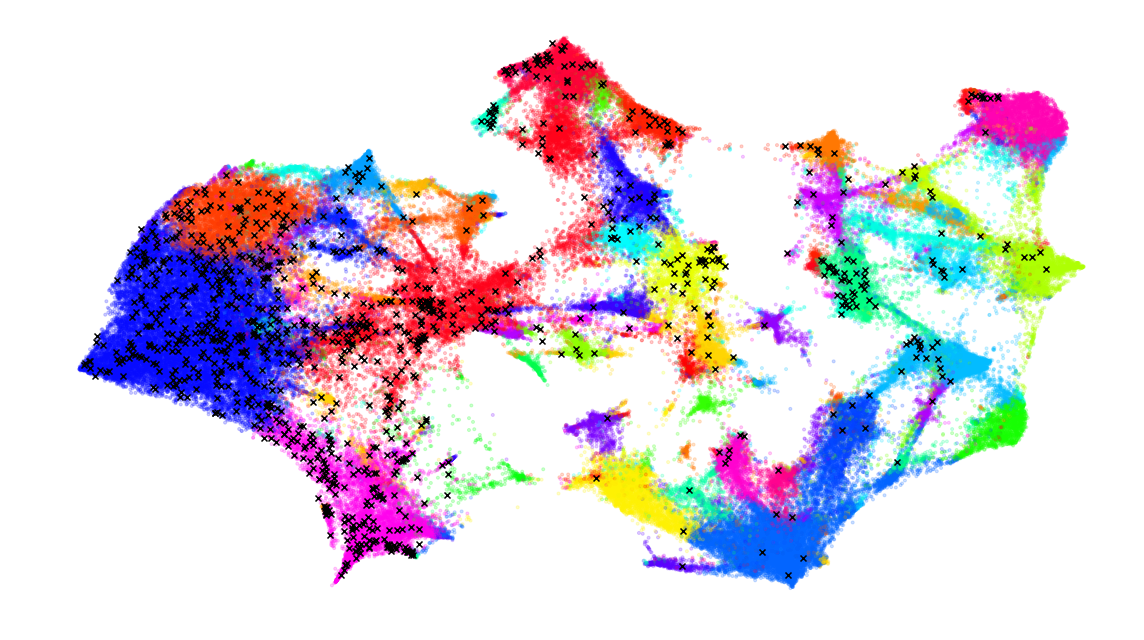

In [4]:
plt.figure(figsize=(16,9))
plt.scatter(kw_umap['umap_x'],kw_umap['umap_y'],
            marker='.',alpha=0.2,cmap='hsv',
            c=kw_umap['topic'])

plt.scatter(ffs_umap[:,0],ffs_umap[:,1],marker='x',alpha=1,c='k')

plt.axis('off')
plt.tight_layout()
plt.savefig('plots/umap/eyekw_and_ffs.png',dpi=300)

### Which Topics are FFS Active in?

In the plot below, positive numbers represent topics where FFS are more active than average, and negative numbers represent topics where FFS are less active than average.

Text(0.5,0,'Fraction of FFS Papers - Fraction of Research')

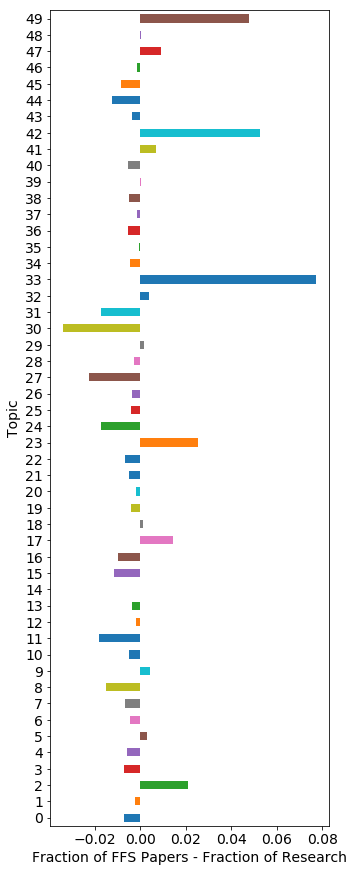

In [38]:
means_ffs_vs_eyekw = pd.DataFrame({'EyeKws':kw_lda_vectors.drop('pubYear',axis=1).mean(),
                                   'FFS':ffs_lda_vectors.mean()})

ax=plt.figure(figsize=(5,15)).gca()
(means_ffs_vs_eyekw['FFS']-means_ffs_vs_eyekw['EyeKws']).plot.barh(ax=ax,rot=0,fontsize=14)
plt.ylabel('Topic',fontsize=14)
plt.xlabel('Fraction of FFS Papers - Fraction of Research',fontsize=14)

### Information on a Topic

Choose a topic number in the first cell below to display information about that topic at the bottom of the notebook - a wordcloud representing keywords in that topic, a visualisation map coloured to show where that topic fits in the map, and a plot showing the change in that topic over time.

After changing the topic number, either run the whole notebook again (Kernel -> Restart & Run All), or run the two cells below (in order) by selecting them and then pressing the "Run" button (or arrow/play type button pointing to the right).

In [13]:
topic = 33

TOPIC 33
Percentage of FFS papers in this topic: 30.08%
Percentage of Eye Research papers in this topic: 15.07%


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


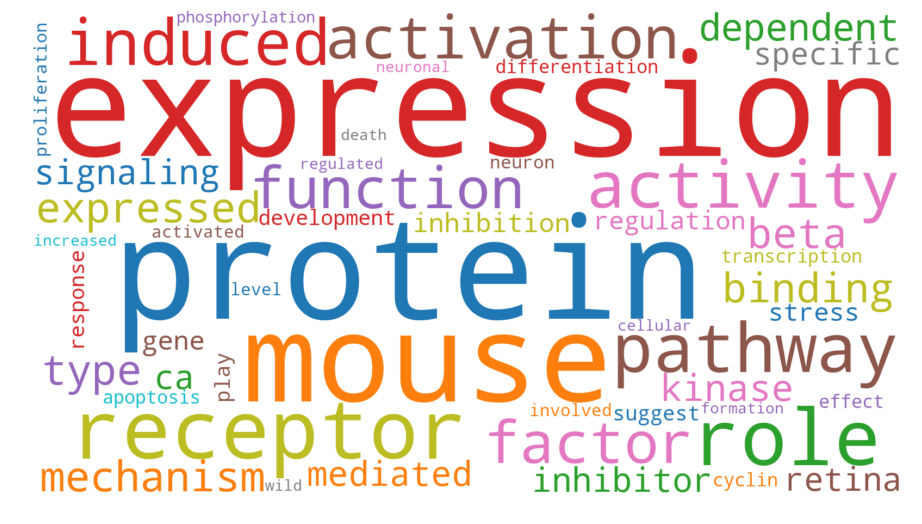

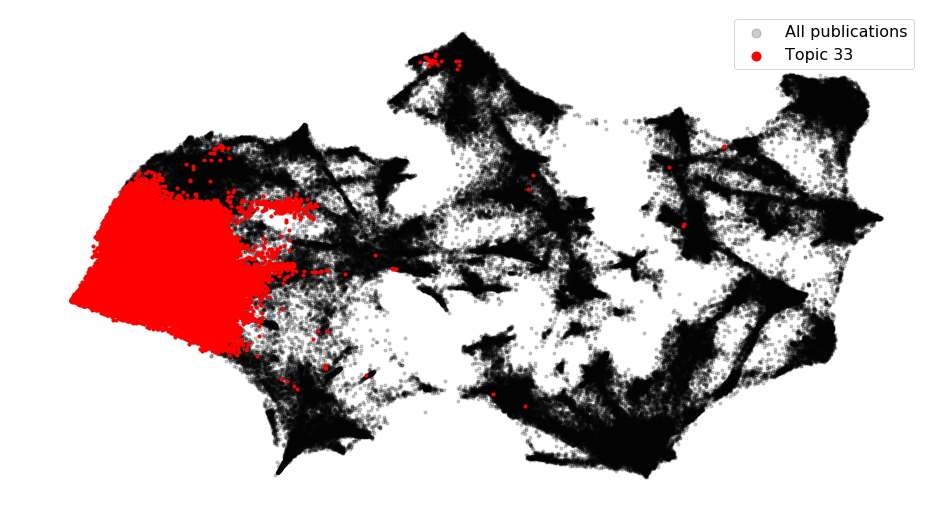

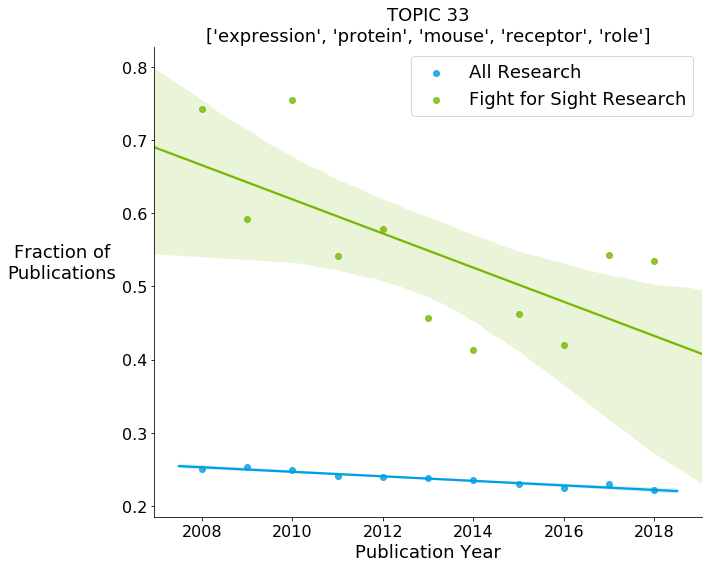

In [14]:
print('=========================')
print('TOPIC',topic)
print('=========================')

print('Percentage of FFS papers in this topic: {:.2%}'.format((ffs_topics==topic).mean()))
print('Percentage of Eye Research papers in this topic: {:.2%}'.format((kw_umap['topic']==topic).mean()))

text = topics.iloc[topic].sort_values(ascending=False).to_dict()

# Generate a word cloud image
wordcloud = WordCloud(width=1600, 
                      height=900,
                      prefer_horizontal=0.9,
                      max_words=50,
                      min_font_size=8,
                      max_font_size=None,
                      font_step=1,
                      background_color='white',
                      relative_scaling='auto',
                      colormap='tab10').generate_from_frequencies(text)

plt.figure(figsize=(16,9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.figure(figsize=(16,9))
plt.scatter(kw_umap['umap_x'],kw_umap['umap_y'],
            marker='.',alpha=0.2,cmap='hsv',
            c='k')

plt.scatter(kw_umap.loc[kw_umap['topic']==topic,'umap_x'],
            kw_umap.loc[kw_umap['topic']==topic,'umap_y'],
            marker='.',alpha=1.0,cmap='hsv',
            c='r')

plt.axis('off')
plt.legend(['All publications','Topic '+str(topic)],fontsize=16,markerscale=3.);

ffs_topic_by_year = ffs_lda_vectors>0.1
ffs_topic_by_year = ffs_topic_by_year.groupby(pubYear).mean()

X_ffs = ffs_topic_by_year[topic].index.values
y_ffs = ffs_topic_by_year[topic].values

kw_pubYear = kw_lda_vectors['pubYear']
kw_topic_by_year = kw_lda_vectors>0.1
kw_topic_by_year = kw_topic_by_year.groupby(kw_pubYear).mean()

X_eyekw = kw_topic_by_year[topic].index.values
y_eyekw = kw_topic_by_year[topic].values

plt.tight_layout()
plt.savefig('plots/topics/topic_'+str(topic)+'_map.png',dpi=300)

plt.figure(figsize=(10,8))
ax = sns.regplot(x=X_eyekw, y=y_eyekw,label='All Research',color='#009fe3')
sns.regplot(x=X_ffs, y=y_ffs,label='Fight for Sight Research',color='#77b800')

leg=plt.legend(fontsize=18)

top5_words = topics.loc[topic].sort_values(ascending=False).head(5).index.tolist()
title = 'TOPIC {:d}\n{:s}'.format(topic,str(top5_words))
plt.title(title,fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlabel('Publication Year',fontsize=18)
plt.ylabel('Fraction of\nPublications',
           rotation=0,fontsize=18, labelpad=60)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.tight_layout()
plt.savefig('plots/topics/topic_'+str(topic)+'_byYear.png',dpi=300)